# **LGM-VIP Data Science Internship Programme**
# **Adavanced Level Task-3**
# **Name: Handwritten equation solver using CNN**

In [1]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unrar is already the newest version (1:5.5.8-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [2]:
!unrar x /content/sample_data/data.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/sample_data/data.rar

Creating    extracted_images                                          OK
Creating    extracted_images/!                                        OK
Extracting  extracted_images/!/!_100071.jpg                                0%  OK 
Extracting  extracted_images/!/!_100077.jpg                                0%  OK 
Extracting  extracted_images/!/!_100082.jpg                                0%  OK 
Extracting  extracted_images/!/!_100085.jpg                                0%  OK 
Extracting  extracted_images/!/!_100088.jpg                                0%  OK 
Extracting  extracted_images/!/!_100259.jpg                                0%  OK 
Extracting  extracted_images/!/!_100620.jpg                                0%  OK 
Extracting  extracted_images/!/!_100626.jpg                                0%  OK 
Ex

In [3]:
import numpy as np 
import pandas as pd 
print(os.listdir("/content"))

['.config', 'sample_data', 'extracted_images']


In [5]:
print(os.listdir("/content/extracted_images"))

['!', '(']


Note - Here I have uploded the Zip Version of DataSet as private Dataset

In [6]:
!pip install split-folders    # Library to split Train and valid Image sets in ImageNet style

In [7]:
import os
import numpy as np
from tqdm import tqdm
from fastai import *
import torch
from fastai.vision import *
%matplotlib inline
from fastai.callbacks import *
import cv2
import pandas as pd
import splitfolders

In [8]:
image_load_size = 64
bs = 24

In [9]:
 def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True    

SEED = 999
seed_everything(SEED)

In [10]:
splitfolders.ratio('/content/extracted_images', output="/content/output", seed=SEED, ratio=(.8, .2)) # default va

Copying files: 2633 files [00:00, 5879.32 files/s]


In [11]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,
                      max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])

In [12]:
data = (ImageList.from_folder(path='/content/output')
        .split_by_folder(train='train',valid='val')
        .label_from_folder()
        .transform(tfms,size = image_load_size,resize_method=ResizeMethod.SQUISH)
        .databunch(path='.',bs=bs)    
        .normalize(imagenet_stats)
)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


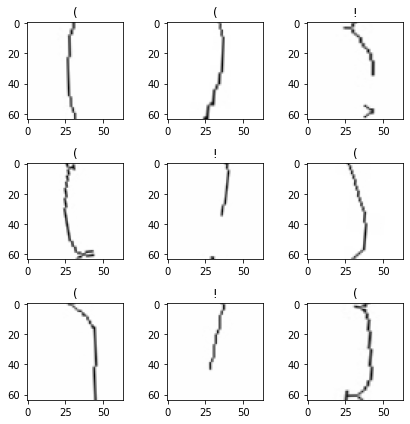

In [13]:
 data.show_batch(3, figsize=(6,6), hide_axis=False)

In [14]:
len(data.classes)

2

In [15]:
 data.classes

['!', '(']

In [16]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [17]:
model = cnn_learner(data,models.densenet161, metrics = [accuracy,error_rate],callback_fns=[partial(SaveModelCallback, monitor='accuracy', name='best_model')])
model.loss_func = FocalLoss()
model.summary()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [96, 32, 32]         14,112     False     
______________________________________________________________________
BatchNorm2d          [96, 32, 32]         192        True      
______________________________________________________________________
ReLU                 [96, 32, 32]         0          False     
______________________________________________________________________
MaxPool2d            [96, 16, 16]         0          False     
______________________________________________________________________
BatchNorm2d          [96, 16, 16]         192        True      
______________________________________________________________________
ReLU                 [96, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [192, 16, 16]        18,432     False     
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 1.20E-02


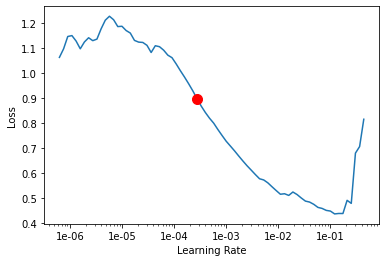

In [18]:
model.lr_find()
model.recorder.plot(suggestion = True)

In [19]:
lr = 2e-3
model.fit_one_cycle(1,slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.120422,0.025549,0.988615,0.011385,03:56


Better model found at epoch 0 with accuracy value: 0.9886147975921631.


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


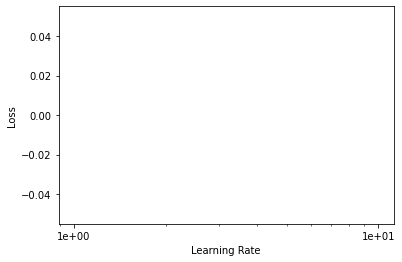

In [20]:
model.unfreeze()
model.lr_find()
model.recorder.plot(suggestion = True)

In [21]:
 model.fit_one_cycle(1,slice(1e-6,lr/10))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.028103,0.005322,0.996205,0.003795,05:37


Better model found at epoch 0 with accuracy value: 0.9962049126625061.


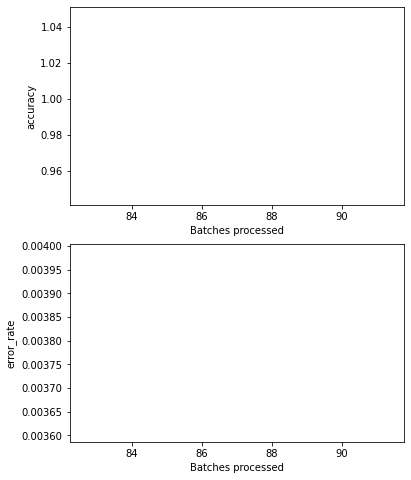

In [22]:
model.recorder.plot_metrics()

In [23]:
model.load('best_model')

Learner(data=ImageDataBunch;

Train: LabelList (2106 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
!,!,!,!,!
Path: /content/output;

Valid: LabelList (527 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
!,!,!,!,!
Path: /content/output;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1)

In [24]:
valid_loss_save_model,accuracy_save_model, error_rate_save_model = model.validate(model.data.valid_dl)
print('valid_loss:', valid_loss_save_model, 'accuracy:', float(accuracy_save_model),'error_rate:',float(error_rate_save_model))

valid_loss: 0.0053218426 accuracy: 0.9962049126625061 error_rate: 0.003795068245381117


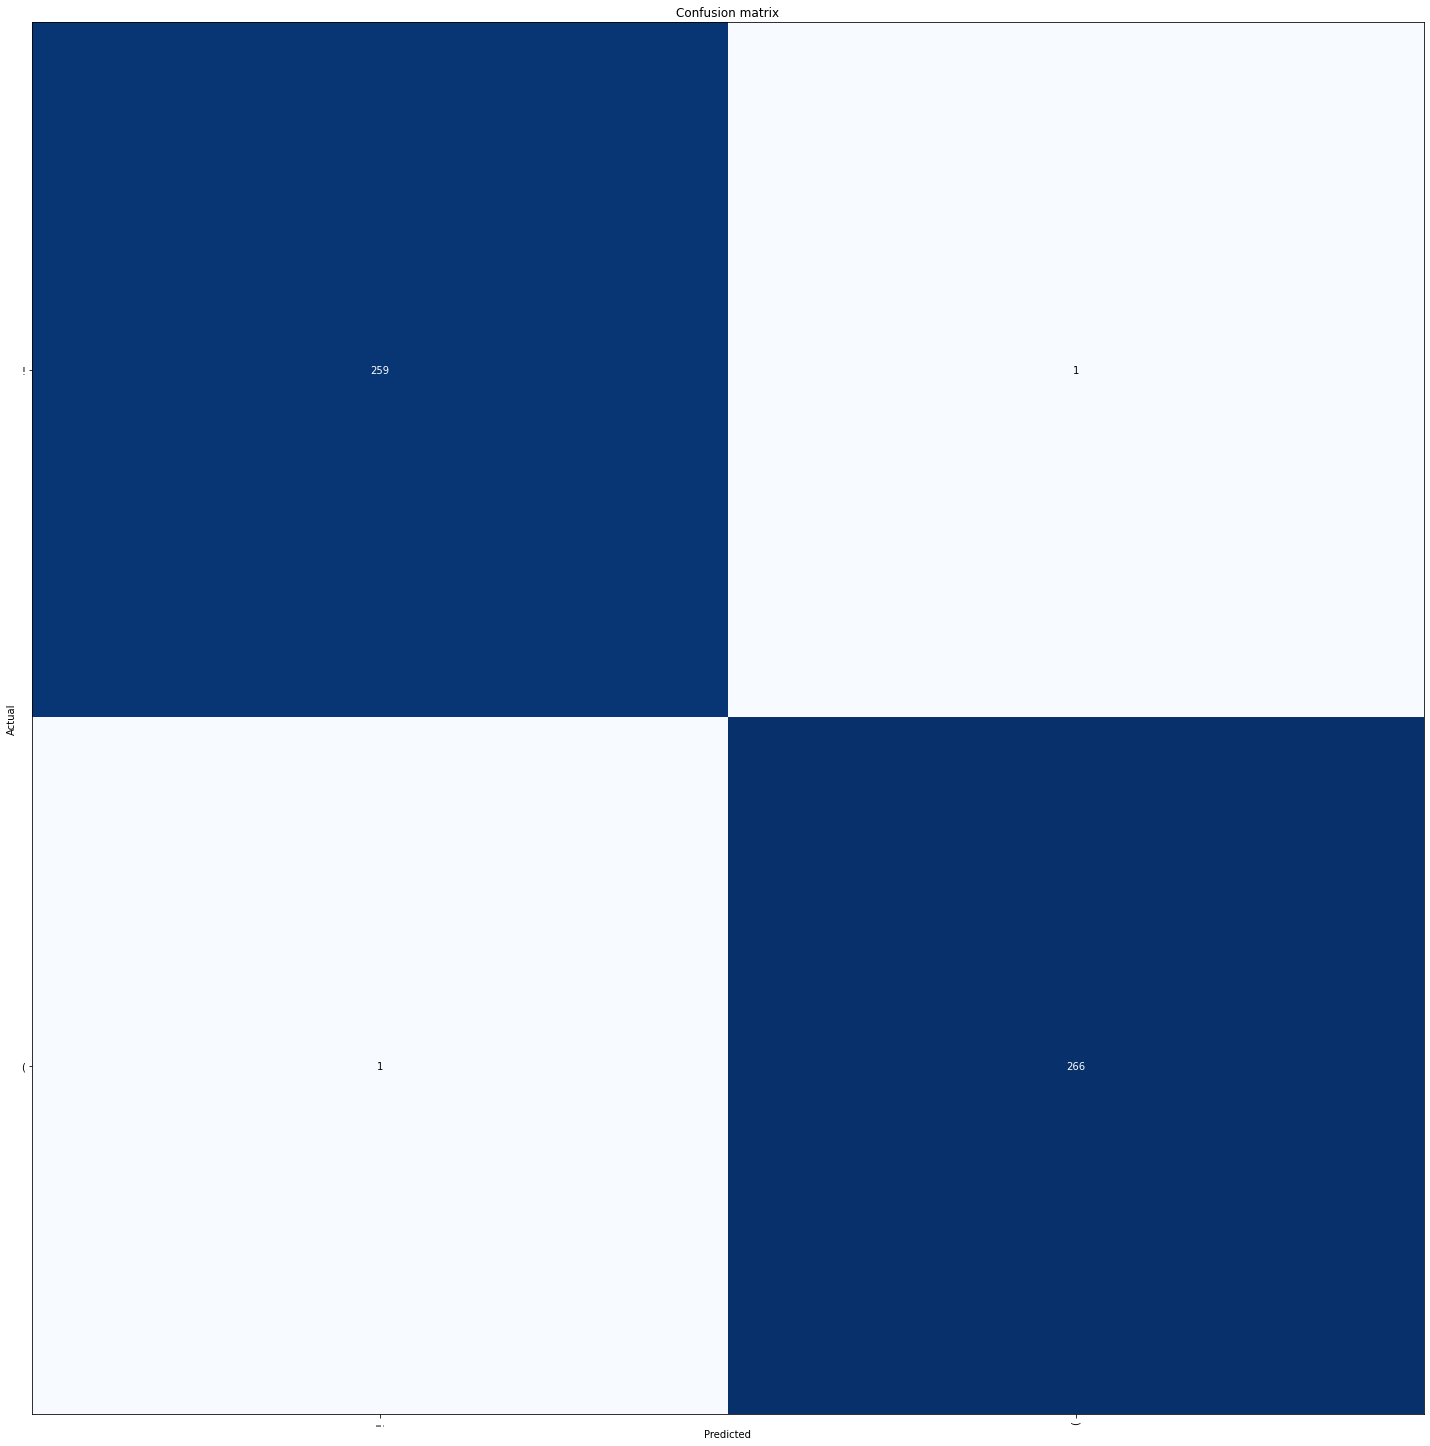

In [25]:
interpreter = ClassificationInterpretation.from_learner(model)
interpreter.plot_confusion_matrix(figsize = (20,20))

In [26]:
interpreter.most_confused(min_val=50)

[]

In [31]:
print(os.listdir('/content/output/val/!'))

['exp20375.jpg', 'exp82427.jpg', 'exp14050.jpg', 'exp24390.jpg', '!_24667.jpg', '!_24385.jpg', '!_32037.jpg', 'exp93309.jpg', '!_21173.jpg', '!_24093.jpg', 'exp105436.jpg', 'exp12590.jpg', '!_102111.jpg', 'exp21455.jpg', '!_32021.jpg', 'exp13471.jpg', '!_99770.jpg', 'exp9778.jpg', 'exp22589.jpg', '!_27266.jpg', 'exp27251.jpg', 'exp88405.jpg', '!_12887.jpg', 'exp22554.jpg', 'exp22342.jpg', '!_19943.jpg', 'exp90436.jpg', 'exp23364.jpg', 'exp28667.jpg', '!_100626.jpg', 'exp87524.jpg', '!_23207.jpg', '!_23801.jpg', '!_22341.jpg', 'exp13322.jpg', 'exp100213.jpg', 'exp14587.jpg', '!_19139.jpg', 'exp28638.jpg', 'exp89445.jpg', 'exp7623.jpg', 'exp15478.jpg', 'exp28650.jpg', '!_104198.jpg', 'exp93838.jpg', 'exp9254.jpg', 'exp85006.jpg', 'exp23847.jpg', 'exp95218.jpg', 'exp20014.jpg', 'exp86674.jpg', 'exp21739.jpg', 'exp13356.jpg', '!_10838.jpg', 'exp13879.jpg', 'exp18354.jpg', 'exp10555.jpg', 'exp11417.jpg', 'exp20101.jpg', '!_13471.jpg', 'exp26142.jpg', 'exp24353.jpg', '!_27835.jpg', 'exp87530

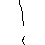

In [32]:
open_image('/content/output/val/!/!_10838.jpg')

In [34]:
pred = model.predict(open_image('/content/output/val/!/!_10838.jpg'))
print(pred[0])

!
